# Import Modules

In [1]:
import os
import glob
import pickle
import numpy as np
import pandas as pd
import librosa
import torch
import pymc as pm
import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
from transformers import Wav2Vec2Processor, Wav2Vec2Model

# Load Pre-Trained Wav2Vec2 Model

In [2]:
# Initialize the pre-trained Mandarin Wav2Vec2 model and processor
processor = Wav2Vec2Processor.from_pretrained("kehanlu/mandarin-wav2vec2")
model = Wav2Vec2Model.from_pretrained("kehanlu/mandarin-wav2vec2")
model.eval()

Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Wav2Vec2Encoder(
    (pos_conv_embed): Wav2Vec2PositionalConvEmbedding(
  

# Convert Audio to Audio Embeddings

In [3]:
def load_audio(file_path, target_sr=16000):
    audio, sr = librosa.load(file_path, sr=None, mono=True)
    if sr != target_sr:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
    audio, _ = librosa.effects.trim(audio)
    return audio, target_sr

def extract_audio_embedding(audio, sr):
    input_values = processor(audio, sampling_rate=sr, return_tensors="pt").input_values
    with torch.no_grad():
        outputs = model(input_values)
    # Average over time dimension to get a fixed-length embedding
    mean_embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return mean_embedding

def load_subject_all_embeddings(subject_dir):
    """
    For a given subject folder, load each of the 29 recordings separately 
    and extract its embedding.
    Returns a dictionary mapping recording number (str) to embedding.
    """
    embeddings = {}
    for file in glob.glob(os.path.join(subject_dir, "*.wav")):
        # Extract recording number from file name (e.g., "1.wav" becomes "1")
        recording_number = os.path.splitext(os.path.basename(file))[0]
        try:
            audio, sr = load_audio(file, target_sr=16000)
            emb = extract_audio_embedding(audio, sr)
            embeddings[recording_number] = emb
        except Exception as e:
            print(f"Error processing {file}: {e}")
    return embeddings

def load_all_subject_embeddings(base_audio_dir, subject_id_ignore=["02010004"], output_file="../subject_embeddings.pkl"):
    """
    Loads embeddings for all subjects (ignoring certain subject ids with contaminated daat).
    Returns a dictionary mapping participant_id (as str) to a dictionary of 29 task embeddings.
    """

    if os.path.exists(output_file):
        # Load embeddings
        print(f"Loading embeddings from {output_file}")
        with open(output_file, "rb") as f:
            subject_embeddings = pickle.load(f)
        print(f"Loaded embeddings for {len(subject_embeddings)} subjects")
    else:
        print("No existing embeddings found. Extracting and saving new embeddings...")
        subject_embeddings = {}
        for subject_folder in os.listdir(base_audio_dir):
            if subject_folder.isdigit() and subject_folder not in subject_id_ignore:
                print(f"Processing {subject_folder}")
                # Ignore non-subject folders
                subject_path = os.path.join(base_audio_dir, subject_folder)
                # Load each of the 29 recordings separately and extract its embedding
                emb_dict = load_subject_all_embeddings(subject_path)
                subject_embeddings[subject_folder] = emb_dict
                print(f"Processed {len(emb_dict)} recordings for {subject_folder}")
        # Save embeddings
        print(f"Saving embeddings to {output_file}")
        with open(output_file, "wb") as f:
            pickle.dump(subject_embeddings, f)
        print(f"Saved embeddings for {len(subject_embeddings)} subjects")

    return subject_embeddings

In [4]:
# Set the base directory where each participant's audio files are stored
base_audio_dir = "../Data/audio_lanzhou_2015" 

In [5]:
subject_embeddings = load_all_subject_embeddings(base_audio_dir)

Loading embeddings from ../subject_embeddings.pkl
Loaded embeddings for 51 subjects


In [6]:
# Load labels for each subject
subjects_information_path = "../Data/audio_lanzhou_2015/subjects_information_audio_lanzhou_2015.xlsx"
labels_df = pd.read_excel(subjects_information_path, dtype={"subject_id": str}) 
labels_df

# Filter and order labels to match the subject_ids (folder names)
subject_ids = list(subject_embeddings.keys())
labels_df = labels_df.set_index('subject_id').loc[subject_ids].reset_index()

# Define the target variable
y = labels_df['type'].values

print("Target variable: ", y)

Target variable:  ['MDD' 'HC' 'HC' 'HC' 'MDD' 'MDD' 'MDD' 'HC' 'HC' 'HC' 'MDD' 'HC' 'HC'
 'HC' 'HC' 'MDD' 'HC' 'HC' 'MDD' 'HC' 'HC' 'HC' 'HC' 'HC' 'HC' 'HC' 'MDD'
 'MDD' 'HC' 'HC' 'MDD' 'MDD' 'HC' 'MDD' 'MDD' 'MDD' 'MDD' 'HC' 'MDD' 'HC'
 'MDD' 'MDD' 'HC' 'HC' 'HC' 'MDD' 'MDD' 'MDD' 'HC' 'MDD' 'HC']


In [7]:
# Convert y from strings to numeric labels: MDD -> 1, HC -> 0
label_map = {'MDD': 1, 'HC': 0}
y = np.array([label_map[label] for label in y])
print(y)

[1 0 0 0 1 1 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 1 0 1 1 1 1
 0 1 0 1 1 0 0 0 1 1 1 0 1 0]


In [8]:
# Define the subgroups based on the experiment:
# Interview recordings:
#   Positive: recordings 1-6
#   Neutral: recordings 7-12
#   Negative: recordings 13-18
# Short story: recording 19
# Reading:
#   Positive: recordings 20-21
#   Neutral: recordings 22-23
#   Negative: recordings 24-25
# Picture description: recordings 26-28
# TAT: recording 29

subgroups = {
    'interview_positive': ['01', '02', '03', '04', '05', '06'],
    'interview_neutral': ['07', '08', '09', '10', '11', '12'],
    'interview_negative': ["13", "14", "15", "16", "17", "18"],
    'short_story': ["19"],
    'reading_positive': ["20", "21"],
    'reading_neutral': ["22", "23"],
    'reading_negative': ["24", "25"],
    'picture_description': ["26", "27", "28"],
    'tat': ["29"]
}

In [9]:
def fuse_subgroup_embeddings(emb_dict, recording_indices):
    """
    Fuse embeddings for subgroups of recordings using average pooling.
    
    Parameters:
        emb_dict (dict): Mapping from recording number (str) to embedding.
        recording_indices (list): List of recording numbers (int) to fuse.
    
    Returns:
        fused (np.ndarray): The fused embedding vector.
    """
    embeddings = []
    for idx in recording_indices:
        key = str(idx)
        if key in emb_dict:
            embeddings.append(emb_dict[key])
        else:
            print(f"Recording {key} not found!")
    embeddings = np.vstack(embeddings)
    
    # Average pooling
    return embeddings.mean(axis=0)

In [10]:
fused_data = {}
for subject_id, emb_dict in subject_embeddings.items():
    print(f"Processing {subject_id}")
    subgroup_fused = {}
    for subgroup_name, indices in subgroups.items():
        fused_embedding = fuse_subgroup_embeddings(emb_dict, indices)
        if fused_embedding is not None:
            subgroup_fused[subgroup_name] = fused_embedding
    if subgroup_fused:
        fused_data[subject_id] = subgroup_fused
print(f"Processed {len(fused_data)} subjects")

Processing 02010003
Processing 02030005
Processing 02030002
Processing 02020004
Processing 02010034
Processing 02010002
Processing 02010005
Processing 02030004
Processing 02030017
Processing 02030010
Processing 02010018
Processing 02020010
Processing 02020021
Processing 02020019
Processing 02020026
Processing 02010011
Processing 02030016
Processing 02020018
Processing 02010010
Processing 02020027
Processing 02020016
Processing 02020011
Processing 02030001
Processing 02030006
Processing 02030008
Processing 02020008
Processing 02010036
Processing 02010009
Processing 02030009
Processing 02030007
Processing 02010037
Processing 02010008
Processing 02020007
Processing 02010006
Processing 02010039
Processing 02010001
Processing 02010023
Processing 02020014
Processing 02010024
Processing 02020025
Processing 02010012
Processing 02010015
Processing 02020022
Processing 02030014
Processing 02020023
Processing 02010014
Processing 02010013
Processing 02010025
Processing 02020015
Processing 02010022


In [11]:
# Define a fixed order for your subgroups:
subgroup_order = [
    'interview_positive', 'interview_neutral', 'interview_negative',
    'short_story', 'reading_positive', 'reading_neutral', 'reading_negative',
    'picture_description', 'tat'
]

# Build the 3D array: one row per subject, each with shape (n_subgroups, feature_dim)
X_sub = []  # List to collect each subject's subgroup embeddings

for subject_id, subgroup_dict in fused_data.items():
    # Ensure that we have all subgroups; if a subgroup is missing, we skip it or fill with zeros.
    subject_embedding = []
    for subgroup in subgroup_order:
        if subgroup in subgroup_dict:
            subject_embedding.append(subgroup_dict[subgroup])
        else:
            # Option: Fill with zeros if a subgroup is missing
            d = list(subgroup_dict.values())[0].shape[0] if subgroup_dict else 768  # default dimension
            subject_embedding.append(np.zeros(d))
    subject_embedding = np.vstack(subject_embedding)  # shape: (n_subgroups, feature_dim)
    X_sub.append(subject_embedding)

# Convert to a NumPy array: shape (n_subjects, n_subgroups, feature_dim)
X = np.stack(X_sub, axis=0)
print(f"X_tensor shape: {X.shape}")

X_tensor shape: (51, 9, 768)


# Fit the Byesian Model

Here, we fit a Bayesian logistic regression model augmented with a latent attention mechanism for fusing the subgroup embeddings.

\[
\begin{aligned}
\textbf{For each subject } i = 1, \dots, M: \quad & \\
\boldsymbol{\alpha}_i &= (\alpha_{i1}, \alpha_{i2}, \dots, \alpha_{iN}) \sim \operatorname{Dirichlet}(\mathbf{1}) \quad \text{(with } \mathbf{1} \in \mathbb{R}^N \text{)} \\
\tilde{\mathbf{x}}_i &= \sum_{j=1}^{N} \alpha_{ij} \, \mathbf{x}_{ij}, \quad \mathbf{x}_{ij} \in \mathbb{R}^d \\
\beta &\sim \mathcal{N}(\mathbf{0}, \mathbf{I}), \quad b \sim \mathcal{N}(0, 1) \\
\operatorname{logit}(\theta_i) &= \beta^\top \tilde{\mathbf{x}}_i + b \quad  \\
\text{or equivalently} \theta_i &= \sigma\left(\beta^\top \tilde{\mathbf{x}}_i + b\right) = \frac{1}{1 + \exp\left(-\left(\beta^\top \tilde{\mathbf{x}}_i + b\right)\right)} \\
y_i &\sim \operatorname{Bernoulli}(\theta_i)
\end{aligned}
\]

In [12]:
# --------------------------
# End-to-End Bayesian Model with Attention Fusion
# --------------------------
M_total, N, d = X.shape     # Number of subjects, subgroups, and embedding dimension

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")

M_train = X_train.shape[0]
trace_file = "trace.nc"

with pm.Model() as model:
    # 1. Attention Weights as Latent Variables
    alpha_prior = np.ones(N, dtype=np.float64)
    # Use training data shape: (M_train, N)
    attn_weights = pm.Dirichlet("attn_weights", a=alpha_prior, shape=(M_train, N))
    
    # 2. Fused Embedding Computation for training subjects
    X_train_tensor = pt.as_tensor_variable(X_train)  # shape: (M_train, N, d)
    # Compute the fused embedding as the weighted sum over subgroups.
    fused_embeddings = pt.sum(attn_weights[:, :, None] * X_train_tensor, axis=1)  # shape: (M_train, d)
    
    # 3. Classification Model (Logistic Regression)
    beta = pm.Normal("beta", mu=0, sigma=1, shape=d)
    intercept = pm.Normal("intercept", mu=0, sigma=1)
    
    logits = pt.dot(fused_embeddings, beta) + intercept  # shape: (M_train,)
    theta = pm.Deterministic("theta", pm.math.sigmoid(logits))
    
    y_obs = pm.Bernoulli("y_obs", p=theta, observed=y_train)
    
    # 4. Posterior Inference: Sample from the joint posterior or load trace if available.
    if os.path.exists(trace_file):
        print("Loading trace from file...")
        trace = az.from_netcdf(trace_file)
    else:
        print("Sampling from the posterior...")
        trace = pm.sample(2000, tune=1000, target_accept=0.95, cores=2, return_inferencedata=True)
        az.to_netcdf(trace, trace_file)

Training set shape: (40, 9, 768), Test set shape: (11, 9, 768)
Loading trace from file...


In [13]:
# -----------------------------------------------------------------------------
# Posterior Predictive Check: Evaluate the model on training data.
with model:
    ppc = pm.sample_posterior_predictive(trace, var_names=["theta"], return_inferencedata=False)

predicted_probs_train = np.mean(ppc["theta"], axis=(0, 1))
predicted_classes_train = (predicted_probs_train >= 0.5).astype(int)
train_accuracy_train = accuracy_score(y_train, predicted_classes_train)
print(f"Training Accuracy: {train_accuracy_train:.2f}")

# ---------------------------------------------------------
# Interpretation:
# - 'attn_weights' holds the latent attention weights for each subject's subgroups.
# - 'fused_embeddings' is the weighted sum of subgroup embeddings.
# - The logistic regression layer (parameters beta and intercept) maps the fused embeddings to probabilities.
# - The model jointly infers both the fusion (attention weights) and the classification parameters.
# ---------------------------------------------------------

Sampling: []


Output()

Training Accuracy: 0.82


## Model Convergence Diagnostics

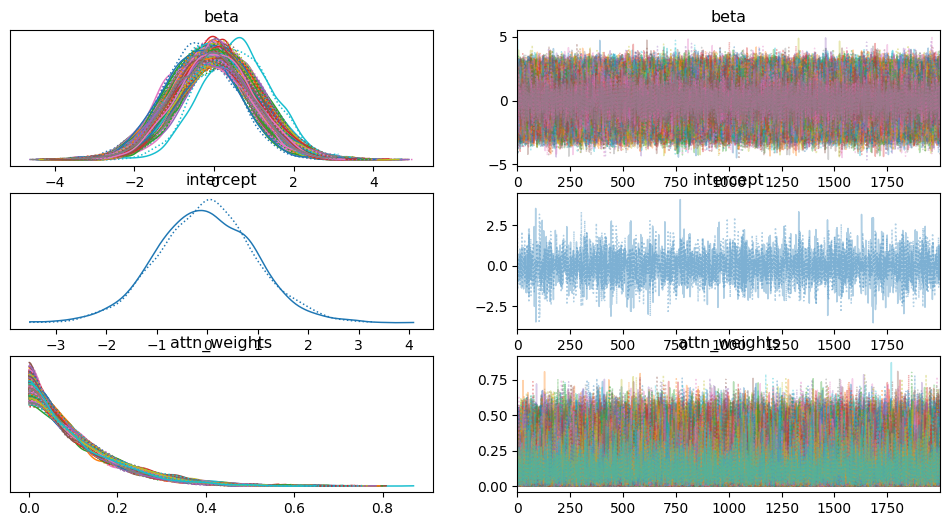

                      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
beta[0]             -0.093  0.996  -1.876    1.862      0.014    0.017   
beta[1]             -0.067  0.992  -1.945    1.799      0.015    0.016   
beta[2]             -0.129  1.001  -1.915    1.874      0.014    0.016   
beta[3]              0.048  0.996  -1.872    1.869      0.015    0.017   
beta[4]             -0.037  0.985  -1.733    1.954      0.013    0.016   
...                    ...    ...     ...      ...        ...      ...   
attn_weights[39, 4]  0.112  0.100   0.000    0.299      0.001    0.002   
attn_weights[39, 5]  0.113  0.099   0.000    0.296      0.001    0.002   
attn_weights[39, 6]  0.112  0.099   0.000    0.297      0.001    0.002   
attn_weights[39, 7]  0.117  0.099   0.000    0.297      0.001    0.002   
attn_weights[39, 8]  0.113  0.101   0.000    0.298      0.002    0.002   

                     ess_bulk  ess_tail  r_hat  
beta[0]                5257.0    2692.0    1.0  
beta[1]      

In [14]:
# Trace plots and summary statistics using ArviZ
az.plot_trace(trace, var_names=["beta", "intercept", "attn_weights"])
plt.show()

summary = az.summary(trace, var_names=["beta", "intercept", "attn_weights"])
print(summary)

## Posterior Predictive Checks

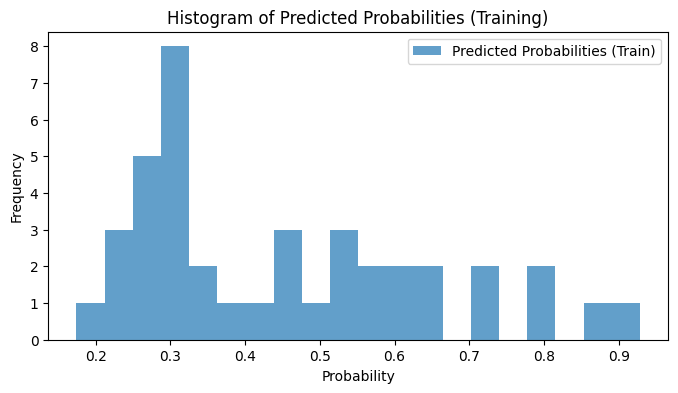

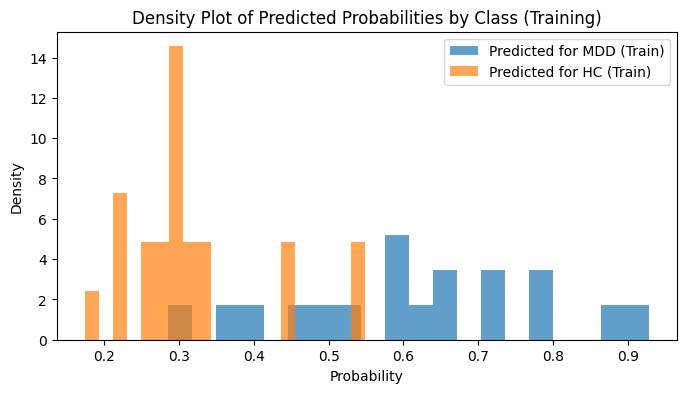

In [15]:
# Plot histogram of predicted probabilities for training data:
plt.figure(figsize=(8, 4))
plt.hist(predicted_probs_train, bins=20, alpha=0.7, label="Predicted Probabilities (Train)")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.title("Histogram of Predicted Probabilities (Training)")
plt.legend()
plt.show()

# Overlay density plots for training data:
plt.figure(figsize=(8, 4))
plt.hist(predicted_probs_train[y_train==1], bins=20, alpha=0.7, label="Predicted for MDD (Train)", density=True)
plt.hist(predicted_probs_train[y_train==0], bins=20, alpha=0.7, label="Predicted for HC (Train)", density=True)
plt.xlabel("Probability")
plt.ylabel("Density")
plt.title("Density Plot of Predicted Probabilities by Class (Training)")
plt.legend()
plt.show()

# Model Check on Testing Data

## 1) Predicting on Testing Data

In [16]:
# -----------------------------------------------------------------------------
# Define a prediction function for new data (test set)
# -----------------------------------------------------------------------------
def predict(trace, X_new, d):
    """
    Predict probabilities for new subjects using the posterior samples from the training model.
    
    Parameters:
      trace: InferenceData object from the training model.
      X_new: NumPy array of shape (M_new, N, d) for new subjects.
      d: embedding dimension.
      
    Returns:
      predicted_probs: NumPy array of shape (M_new,) with predicted probabilities.
    """
    M_new = X_new.shape[0]
    # Use the posterior mean of attn_weights for prediction on new data.
    attn_weights_mean = trace.posterior["attn_weights"].values.mean(axis=(0, 1))  # shape: (M_train, N)
    # Note: For prediction on new data, you might want to build a separate mechanism 
    # to infer attention weights for new subjects. Here, we assume a simple approach:
    # For simplicity, we use the mean of training attention weights and apply it to test data.
    # This is a simplification and ideally, you'd want to infer attention weights on new data.
    attn_weights_mean_new = attn_weights_mean.mean(axis=0)  # average weight across training subjects, shape: (N,)
    # Compute fused embeddings for new subjects using these fixed weights:
    fused_embeddings_new = np.sum(attn_weights_mean_new[None, :, None] * X_new, axis=1)  # shape: (M_new, d)
    
    # Flatten beta and intercept from the posterior.
    beta_all = trace.posterior["beta"].values.reshape(-1, d)
    intercept_all = trace.posterior["intercept"].values.reshape(-1)
    
    # For prediction, sample a subset of posterior samples
    n_samples = 100
    sample_indices = np.random.choice(beta_all.shape[0], size=n_samples, replace=False)
    
    preds = []
    for idx in sample_indices:
        beta_sample = beta_all[idx]
        intercept_sample = intercept_all[idx]
        logits_sample = np.dot(fused_embeddings_new, beta_sample) + intercept_sample
        probs_sample = 1 / (1 + np.exp(-logits_sample))
        preds.append(probs_sample)
    preds = np.array(preds)  # shape: (n_samples, M_new)
    predicted_probs = preds.mean(axis=0)
    
    return predicted_probs

In [17]:
# -----------------------------------------------------------------------------
# Predict on Test Set
# -----------------------------------------------------------------------------
predicted_probs_test = predict(trace, X_test, d)
predicted_classes_test = (predicted_probs_test >= 0.5).astype(int)
test_accuracy = accuracy_score(y_test, predicted_classes_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

Test Accuracy: 0.64


## 2) Prediction Uncertainty on Testing Data

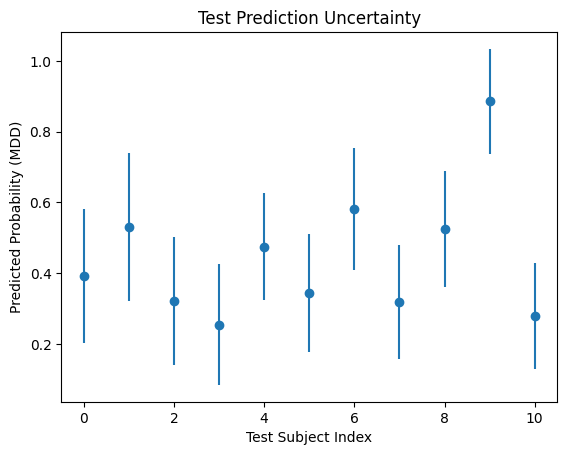

In [18]:
n_samples = 100

# Extract beta and intercept from the posterior (flatten over chains and draws).
beta_all = trace.posterior['beta'].values.reshape(-1, d)         # shape: (total_samples, d)
intercept_all = trace.posterior['intercept'].values.reshape(-1)    # shape: (total_samples,)

# Extract and average attention weights over chains and draws.
# trace.posterior['attn_weights'] has shape (n_chains, n_draws, M_train, N) for training subjects.
# For test data, a common approach is to use the average attention weights computed on the training set,
# or to infer attention weights for the test set separately (if your model supports it).
# Here, for simplicity, we use the posterior mean of the training attn_weights averaged over subjects.
attn_weights_mean_train = trace.posterior['attn_weights'].values.mean(axis=(0, 1))  # shape: (M_train, N)
# We compute an overall mean weight vector across training subjects:
attn_weights_mean = attn_weights_mean_train.mean(axis=0)  # shape: (N,)

# Compute fused embeddings for each test subject using these fixed attention weights.
# X_test has shape (M_test, N, d)
fused_embeddings_test = np.sum(attn_weights_mean[None, :, None] * X_test, axis=1)  # shape: (M_test, d)

# Sample a subset of posterior samples for beta and intercept.
sample_indices = np.random.choice(beta_all.shape[0], size=n_samples, replace=False)

preds = []
for idx in sample_indices:
    beta_sample = beta_all[idx]
    intercept_sample = intercept_all[idx]
    # For each test subject, compute logits and then probability.
    logits_sample = np.dot(fused_embeddings_test, beta_sample) + intercept_sample
    probs_sample = 1 / (1 + np.exp(-logits_sample))
    preds.append(probs_sample)

preds = np.array(preds)  # shape: (n_samples, M_test)
pred_mean = preds.mean(axis=0)  # averaged predicted probability per test subject, shape: (M_test,)
pred_std = preds.std(axis=0)    # standard deviation per test subject, shape: (M_test,)

plt.errorbar(range(len(pred_mean)), pred_mean, yerr=pred_std, fmt='o')
plt.xlabel("Test Subject Index")
plt.ylabel("Predicted Probability (MDD)")
plt.title("Test Prediction Uncertainty")
plt.show()

## 3) Callibration Check

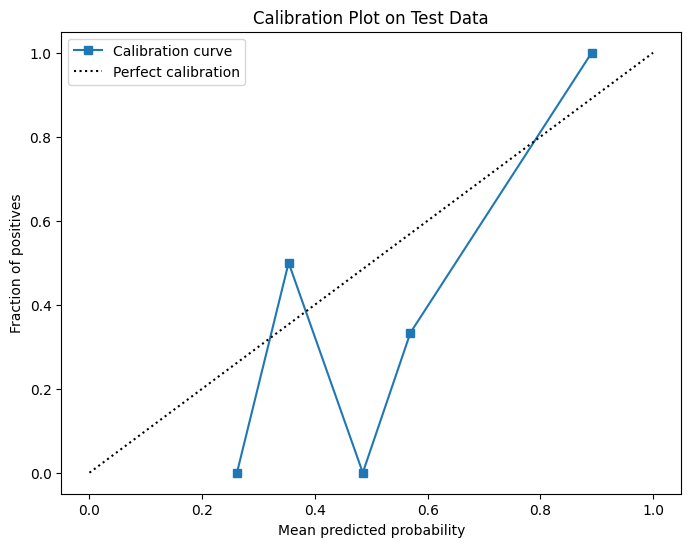

Brier score: 0.203


In [19]:
# Calibration curve: compare predicted probabilities to true frequencies.
# predicted_probs from ppc (as computed above) and true labels y.
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, predicted_probs_test, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Calibration curve")
plt.plot([0, 1], [0, 1], "k:", label="Perfect calibration")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Plot on Test Data")
plt.legend()
plt.show()

# Compute the Brier score:
brier = brier_score_loss(y_test, predicted_probs_test)
print(f"Brier score: {brier:.3f}")

## 4) Comparative Metrics

In [20]:
auc = roc_auc_score(y_test, predicted_probs_test)
precision = precision_score(y_test, (predicted_probs_test >= 0.5).astype(int))
recall = recall_score(y_test, (predicted_probs_test >= 0.5).astype(int))
f1 = f1_score(y_test, (predicted_probs_test >= 0.5).astype(int))
accuracy = accuracy_score(y_test, (predicted_probs_test >= 0.5).astype(int))

print("Accuracy:", accuracy)
print("AUC-ROC:", auc)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Accuracy: 0.6363636363636364
AUC-ROC: 0.6785714285714286
Precision: 0.5
Recall: 0.5
F1-Score: 0.5
